In [1]:
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch, arrowhead_marker
import seaborn as sns
import ipywidgets as widgets
from highlight_text import  ax_text, fig_text
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import warnings
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
import matplotlib as mpl

warnings.simplefilter(action="ignore", category=FutureWarning)

#Read data
df = pd.read_csv('Footballdata/Season/EPL.csv', encoding='latin-1', low_memory = False)

#Temporary because teams are getting combined together
df['name'] = df['name'].str.cat(df['teamId'], sep='_')

#Adjust to pitch
df['x'] = df['x']*1.2
df['y'] = df['y']*.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*.8

df = df.loc[(df['y'] > 0)]
df = df.loc[(df['y'] < 80)]

#remove
df = df.loc[~(df['type_displayName'] == 'Challenge')]
df = df.loc[~((df['type_displayName'] == 'Aerial') & (df['outcomeType_displayName'] == 'Unsuccessful'))]

#Set passer and receiver
df['passer'] = df['name'].where(df['type_displayName'] == 'Pass', '')
df['recipient'] = df['name'].shift(-1).where(df['type_displayName'] == 'Pass', '')

#Finding previous event to filter out setpieces
df['prevevent'] = df['type_displayName'].shift(1)

#Finding the event before the previous event to filter for Aerials
df['nextevent'] = df['type_displayName'].shift(-1)

#Remove passes that come after fouls and cards, potential set pieces
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'Foul'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'Card'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'CornerAwarded'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'OffsideGiven'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'SubstitutionOn'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'FormationChange'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'Start'))]

#length of passes
df['passlength'] = np.sqrt(np.square(df['endX']-df['x']) + np.square(df['endY']-df['y']))

#main df includes all successful passes
df = df[(df['type_displayName']=='Pass') & (df['outcomeType_displayName']=='Successful')]

In [2]:
#Half Space Passes
df['HS_Pass'] = np.where(((df['y'].between(16.88,29.44)) | (df['y'].between(50.56,63.12))) & (df['x'].between(80,120)),1,0)
HSPassdf = df.loc[df['HS_Pass'] == 1]

#Zone 14 Passes
df['Z14_Pass'] = np.where((df['x'].between(80,99.6)) & (df['y'].between(29.44,50.56)),1,0)
Z14Passdf = df.loc[df['Z14_Pass'] == 1]

#Outward Distribution
df['Outward_Pass'] = np.where((df['y'].between(16.88,63.12)) & 
                             ((df['endY'].between(0,16.88)) | (df['endY'].between(63.12,80))),1,0)
OPassdf = df.loc[df['Outward_Pass'] == 1]

#Outward Distribution
df['Cutbacks'] = np.where(((df['x'].between(99.6,120)) & ((df['y'].between(0,29.44)) | (df['y'].between(50.56,80)))) &
                          ((df['endX'].between(99.6,113.04)) & (df['endY'].between(29.44,50.56))),1,0)
Cutbacksdf = df.loc[df['Cutbacks'] == 1]

In [6]:
#List
HSPass_list = HSPassdf.groupby(['name','teamId']).size().reset_index().rename(columns={0:'Half-Space Passes'}).sort_values('name', ascending = True).reset_index()
del HSPass_list['index']

Z14Pass_list = Z14Passdf.groupby(['name','teamId']).size().reset_index().rename(columns={0:'Zone 14 Passes'}).sort_values('name', ascending = True).reset_index()
del Z14Pass_list['index']

OPass_list = OPassdf.groupby(['name','teamId']).size().reset_index().rename(columns={0:'Outward Distribution'}).sort_values('name', ascending = True).reset_index()
del OPass_list['index']

Cutbacks_list = Cutbacksdf.groupby(['name','teamId']).size().reset_index().rename(columns={0:'Cutbacks'}).sort_values('name', ascending = True).reset_index()
del Cutbacks_list['index']

passlist = pd.merge(pd.merge(pd.merge(HSPass_list, OPass_list, how='outer'), Z14Pass_list, how='outer'), Cutbacks_list, how='outer')
passlist.fillna(0, inplace=True)
passlist.rename(columns = {'teamId':'Team', 'name':'Player'},inplace = True)
passlist = passlist.sort_values('Zone 14 Passes', ascending= False).reset_index(drop = True)
passlist.index += 1

passlist["Half-Space Passes"] = passlist["Half-Space Passes"].astype(int)
passlist["Zone 14 Passes"] = passlist["Zone 14 Passes"].astype(int)
passlist["Outward Distribution"] = passlist["Outward Distribution"].astype(int)
passlist["Cutbacks"] = passlist["Cutbacks"].astype(int)

passlist['Player'] = passlist['Player'].str.split('_').str[0]

passlist=passlist[['Player','Team','Outward Distribution','Zone 14 Passes','Cutbacks','Half-Space Passes']]
#passlist.to_csv(r'C:\Users\user\Downloads\Passes\PL.csv', encoding='latin-1')

passlist.head(10)

,Player,Team,Outward Distribution,Zone 14 Passes,Cutbacks,Half-Space Passes
1,Rodri,Manchester City,620,130,1,186
2,Thomas Partey,Arsenal,388,123,0,89
3,Alexis Mac Allister,Brighton,233,112,0,91
4,Martin Ødegaard,Arsenal,161,109,4,168
5,Ilkay Gündogan,Manchester City,182,78,1,118
6,Moisés Caicedo,Brighton,265,72,4,115
7,Granit Xhaka,Arsenal,206,70,12,142
8,Bruno Fernandes,Manchester United,186,65,12,148
9,Pierre-Emile Højbjerg,Tottenham,404,61,2,81
10,Pascal Groß,Brighton,191,49,7,116


In [4]:
#Combo box, choose players
options = df["name"].unique()
options = options.tolist()

options = [x for x in options if str(x) != 'nan']
playerlist = widgets.Combobox(
    placeholder='Enter a name',
    options=options,
    description='Player:',
    ensure_option=True,
    disabled=False
)
playerlist

Combobox(value='', description='Player:', ensure_option=True, options=('Eberechi Eze_Crystal Palace', 'Joachim…

In [8]:
player = playerlist.value

#All Passes from player
Successful_Passes = Cutbacksdf.loc[(Cutbacksdf['name']==player)]

successful = len(Successful_Passes.index)

#Retrieve team name from the passes
team = Successful_Passes['teamId'].unique()
team = team[0]

#Retrieve Opposition team
oppo = df.loc[(df['teamId']!= team)]
oppo = oppo['teamId'].unique()
oppo = oppo[0]


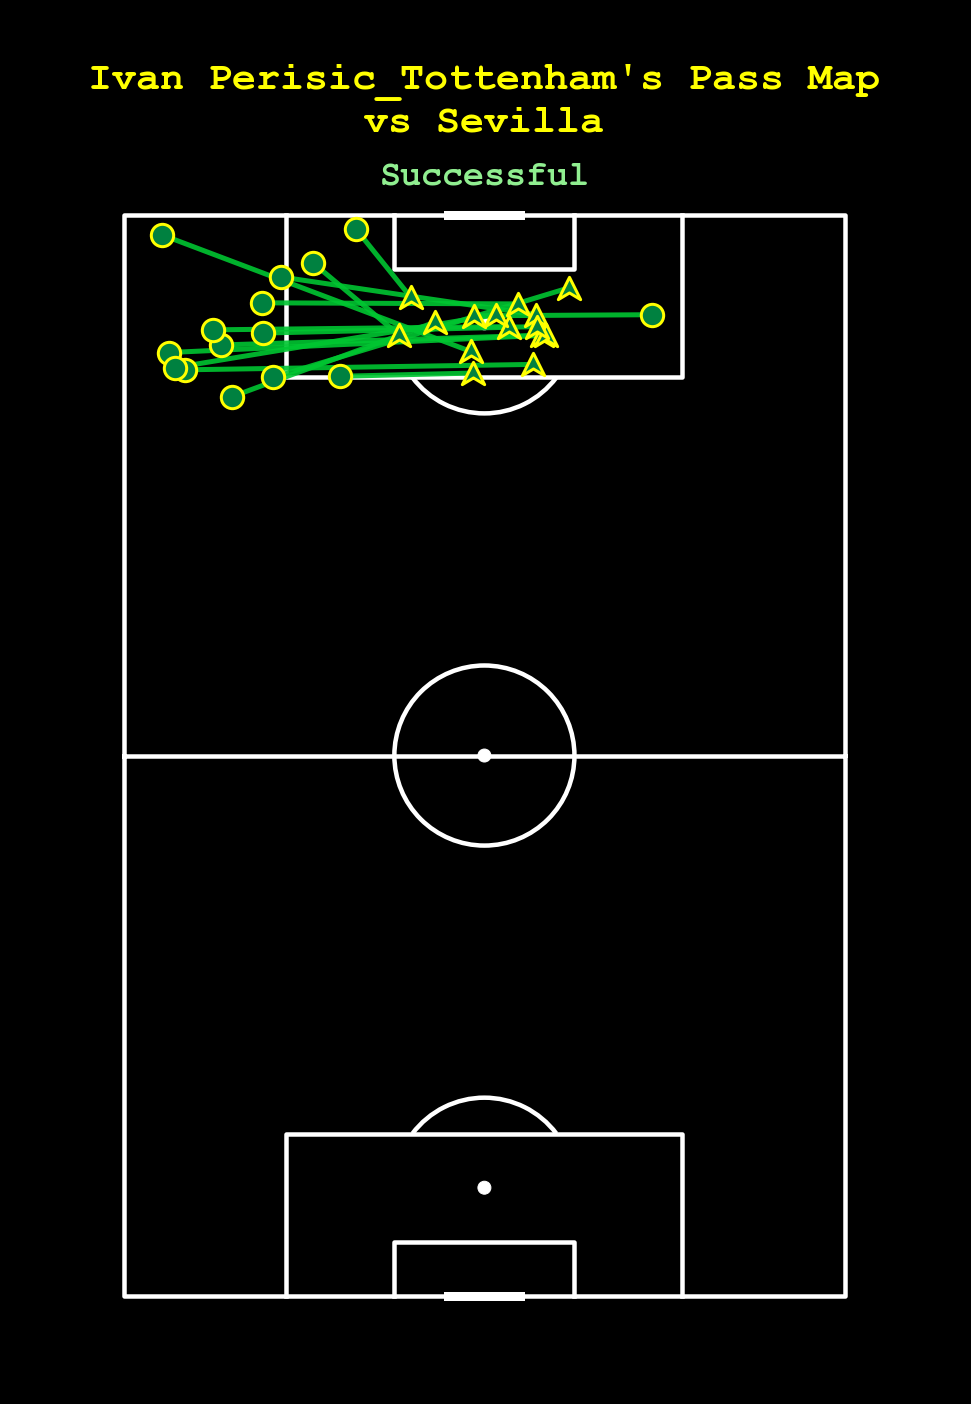

In [9]:
#Set up pitch
#mpl.rcParams['figure.dpi'] = 300
pitch = VerticalPitch(pitch_type='statsbomb', 
                  pitch_color='#000000', line_color='white',half = False,
                  line_zorder=1, linewidth=4.5, spot_scale=0.006)

fig,ax = pitch.draw(figsize=(30, 20), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#000000')

#Inverse the y-axis
plt.gca().invert_xaxis()

#Successful Passes
pitch.scatter(Successful_Passes.x,Successful_Passes.y, edgecolors= 'yellow', c='#008140',
              s = 500, zorder=4, ax=ax, marker = 'o', linewidth=3)

pitch.lines(Successful_Passes.x,Successful_Passes.y,Successful_Passes.endX,Successful_Passes.endY,
            ax=ax, color= '#00c631', lw=5, alpha = 0.9)

pitch.scatter(Successful_Passes.endX,Successful_Passes.endY, edgecolors= 'yellow', c='#008140',marker=arrowhead_marker,
              s = 500, zorder=4, ax=ax, linewidth=3)

#Title
plt.text(40,121,player+"'s Pass Map\nvs Sevilla\n\n",color='yellow', ha='center',
          size=40, fontfamily = "Courier New", fontweight = "bold")

highlight_textprops =\
    [{"color": "lightgreen","fontweight": 'bold'}
    ]

Title = fig_text(s = "<Successful>",
        x = 0.5, y = 0.87, highlight_textprops = highlight_textprops ,color='yellow',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=35)

#Space
ax.text(45, 142, 'Space', va='center', ha='left', fontsize=25, color='black',fontweight='bold',fontfamily='Courier New')
ax.text(-5, -10, 'Space', va='center', ha='left', fontsize=25, color='black',fontweight='bold',fontfamily='Courier New')
ax.text(93, -10, 'Space', va='center', ha='left', fontsize=25, color='black',fontweight='bold',fontfamily='Courier New')

plt.show()

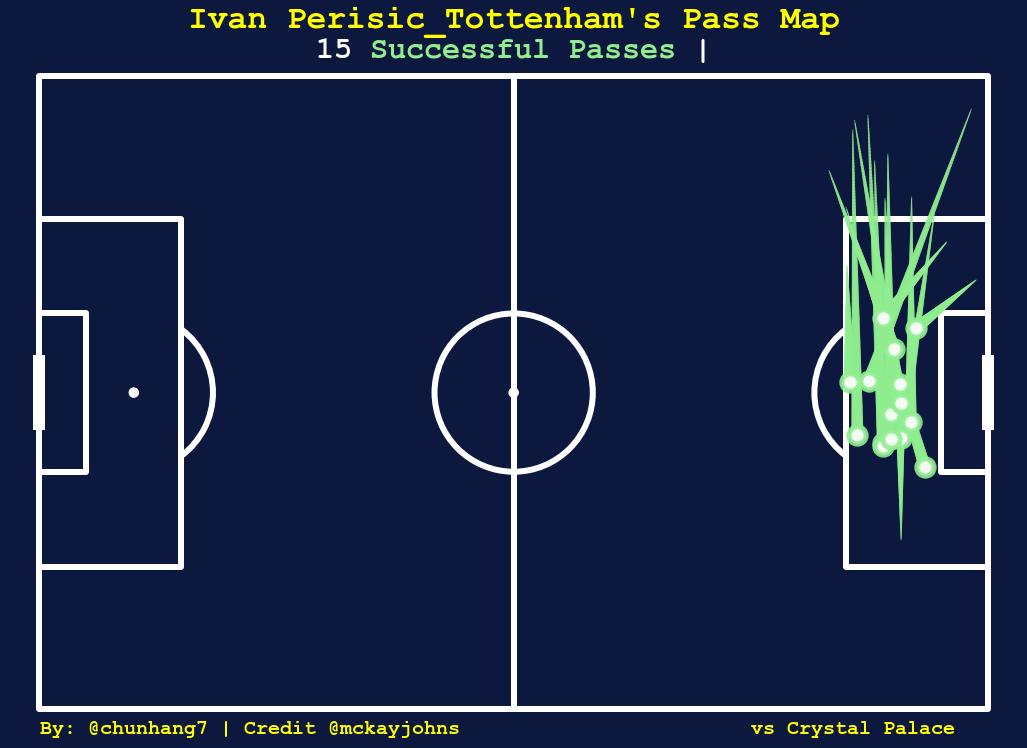

In [10]:
#Make the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#0d183f', line_color='white',linewidth=6, spot_scale=0.005)
fig, ax = pitch.draw(figsize=(15, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#0d183f')

#Inverse y-axis
plt.gca().invert_yaxis()

#Plot Successful Passes
pitch.lines(Successful_Passes.x,Successful_Passes.y,Successful_Passes.endX,Successful_Passes.endY,
            comet=True,ax=ax, linewidth=12, capstyle='round', 
            alpha=0.6, color ='lightgreen')

pitch.scatter(Successful_Passes['endX'], Successful_Passes['endY'],
              edgecolors= "lightgreen", c="w", s = 300, zorder=4, ax=ax, 
              marker = 'o', alpha = 0.9,linewidths=5, label='Successful Passes')

    
#Title & Annotations
fig.suptitle(player +"'s Pass Map\n", fontsize=33, color='yellow',
            fontfamily = "Courier New", fontweight = "bold",y=0.94)

highlight_textprops =\
    [{"color": "lightgreen","fontweight": 'bold'}
    ]

Title = fig_text(s = str(successful) + " <Successful Passes> | " ,
        x = 0.509, y = 0.9, highlight_textprops = highlight_textprops ,color='white',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=30);

#Credits
ax.text(0.1, -2.5, 'By: @chunhang7 | Credit @mckayjohns', va='center', ha='left', fontsize=20, color='yellow',
        fontweight = "bold",fontfamily = "Courier New")

ax.text(90, -2.5, "vs "+ oppo, va='center', ha='left', fontsize=20, color='yellow',
        fontweight = "bold",fontfamily = "Courier New")

plt.show()